This is analysis is based on the daily reports from the John Hopkins GitHub Repository: https://github.com/CSSEGISandData/COVID-19.

The data in the charts has been normalized both with regard to population and time. The horizontal axes are the number of days since Confirmed occurrences exceed the population for the region divided by ten million. For the linear scale charts, the vertical axes are a multiplier for each day of those occurrences on the first day. The log scale charts are the log base 10 values of the multipliers. This methodology was first proposed by Kevin Drum of Mother Jones who has kept a running account of the COVID-19 trends on his blog: https://www.motherjones.com/kevin-drum/.

The notebook is parameterized for US states, with a special cases for Italy and the Hubei province in China. Add or remove names from the lists to present your charts of interest. Similar to the United States, companion notebooks could be created for states and provinces in other regions.

For a more complete listing of the available global data sources take a look at the COVID-19 dataset clearinghouse: https://asone.ai/polymath/index.php?title=COVID-19_dataset_clearinghouse.

The COVID Tracking project has detailed daily numbers for the US: https://github.com/COVID19Tracking/covid-tracking-data

The CDC tracks estimated deaths in US states: https://data.cdc.gov/api/views/r8kw-7aab/rows.csv?accessType=DOWNLOAD&api_foundry=true

The CDC tracks estimated deaths in US counties: https://data.cdc.gov/api/views/kn79-hsxy/rows.csv?accessType=DOWNLOAD

The US county population and incident data is provided by USAFacts: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

Esri has data sets associated with COVID-19: https://coronavirus-disasterresponse.hub.arcgis.com/#get-data

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from sodapy import Socrata
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import zipfile as zf
import math
import sys, os

Subdirectories

In [2]:
rootdir = os.path.realpath("..")
datadir = os.path.join(rootdir, "data")
popdir = os.path.join(datadir, "pop")
deathdir = os.path.join(datadir, "death")

List of counties to exclude

In [3]:
county_exclude_locs = ["36061,New York County,NY"]

Translate location name to abbreviation

In [4]:
def _state_loc_abbrev(loc):
    """
    Translate state location name to two character abbreviation
    
    Parameters
    ---------
    loc : string
        State location name
        
    Returns
    -------
    Two character abbreviation
    """
    xlator = {
        "New York" : "NY",
        "New Jersey" : "NJ",
        "Washington" : "WA",
        "California" : "CA",
        "Michigan" : "MI",
        "Massachusetts" : "MA",
        "Illinois" : "IL",
        "Florida" : "FL",
        "Louisiana" : "LA",
        "Pennsylvania" : "PA",
        "Colorado" : "CO",
        "Georgia" : "GA",
        "Texas" : "TX",
        "Connecticut" : "CT",
        "North Carolina" : "NC",
        "Indiana" : "IN",
        "Alabama" : "AL",
        "Alaska" : "AK",
        "Arizona" : "AZ",
        "Arkansas" : "AR",
        "Delaware" : "DE",
        "District of Columbia" : "DC",
        "Hawaii" : "HI",
        "Idaho" : "ID",
        "Iowa" : "IA",
        "Kansas" : "KS",
        "Kentucky" : "KY",
        "Maine" : "ME",
        "Maryland" : "MD",
        "Minnesota" : "MN",
        "Mississippi" : "MS",
        "Missouri" : "MO",
        "Montana" : "MT",
        "Nebraska" : "NE",
        "Nevada" : "NV",
        "New Hampshire" : "NH",
        "New Mexico" : "NM",
        "North Dakota" : "ND",
        "Ohio" : "OH",
        "Oklahoma" : "OK",
        "Oregon" : "OR",
        "Rhode Island" : "RI",
        "South Carolina" : "SC",
        "South Dakota" : "SD",
        "Tennessee" : "TN",
        "Utah" : "UT",
        "Vermont" : "VT",
        "Virginia" : "VA",
        "West Virginia" : "WV",
        "Wisconsin" : "WI",
        "Wyoming" : "WY",
    }
    return xlator.get(loc, "")

Generate list of dates

In [5]:
def _date_range(start, end):
    """
    Generate dates in the form: <dd>-<mm>-<yyyy>

    Parameters
    ----------
    start : string
        Start date in range.
    end : string
        End date in range.

    Returns
    -------
    Sequence of dates.

    """
    start_date = start.split('-')
    sdate = date(int(start_date[2]), int(start_date[0]), int(start_date[1]))
    end_date = end.split('-')
    edate = date(int(end_date[2]), int(end_date[0]), int(end_date[1]))
    
    delta = edate - sdate
    
    i = 0
    while i < delta.days + 1:
        idate = sdate + timedelta(days = i)
        day = idate.strftime("%m-%d-%Y")
        yield day
        i += 1

Extract incidents from John Hopkins daily reports

In [6]:
def _jh_trend(trend_report, scope, category, locs, trend):
    """
    Parameters:
        trend_report - raw data organized by date: dictionary of dataframes
        scope - level of analysis, e.g. country (0), state (1), county(2): integer
        category - type of trend, e.g. Confirmed, Deaths, Recovered, Active: string
        locs - locations to analyze, e.g. Italy, etc.: list of strings
        trend - trend tables: dictionary of dataframes
    """
    for loc in locs:
        if scope == 2:
            loc_split = loc.split(',')
            county_fips = int(loc_split[0])
            county_name = loc_split[1]
            state_abbrev = loc_split[2]
            t = trend[category][(trend[category]['FIPS'] == county_fips)]['Threshold']
        else:
            t = trend[category][(trend[category]['Location'] == loc)]['Threshold']

        incident_threshold = t.item()
        
        j = 0
        for idate in _date_range(start, end_date):
            incident_report = trend_report[idate]
            if scope == 2 and not "FIPS" in incident_report.columns:
                continue
                
            total_incidents = 0
            
            label = []
            if "Country/Region" in incident_report.columns:
                # Early reports use 'Country/Region' and 'Province/State' column labels
                label.append(incident_report.columns[1])
                label.append(incident_report.columns[0])
            else:
                # later reports use 'Country_Region' and 'Province_State'
                label.append(incident_report.columns[3])
                label.append(incident_report.columns[2])
                label.append(incident_report.columns[0])
                assert label[0] == "Country_Region" and label[1] == "Province_State" and label[2] == "FIPS"
                
            if scope == 2:
                incident_df = incident_report[(incident_report[label[scope]] == county_fips)]
            else:
                incident_df = incident_report[(incident_report[label[scope]] == loc)]
                
            # Early reports do not have all categories
            if incident_df.empty or category not in incident_df.columns:
                continue
            
            if scope == 2:
                series_loc = county_fips
                loc = "{0},{1}".format(county_name, state_abbrev)
            else:
                series_loc = loc
                
                # Reports have changed how they list the United Kingdom
                if loc == "United Kingdom":
                    if len(incident_df) == 0:
                        series_loc = "UK"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]

                # Reports have changed how they list South Korea
                if loc == "South Korea":
                    if len(incident_df) == 0:
                        series_loc = "Republic of Korea"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
                    if len(incident_df) == 0:
                        series_loc = "Korea, South"
                        incident_df = incident_report[(incident_report[label[scope]] == series_loc)]
              
            incidents_by_scope = incident_report.groupby([label[scope]])[category].sum()
            incident_series = incidents_by_scope.loc[[series_loc]]
            if incident_series.size == 0:
                continue

            total_incidents = incident_series.tolist()[0]

            try:
                # Replace state incidents with available data from CSSE US tracking
                if scope == 1 and idate in daily_us_report.keys():
                    us_day_report = daily_us_report[idate]
                    daily_series = us_day_report[(us_day_report[label[scope]] == loc)]
                    if len(daily_series) > 0 and category in daily_series.columns:
                        alt_incidents = daily_series[category].item()
                        if not np.isnan(alt_incidents):
                            total_incidents = alt_incidents
            except NameError:
                # Dataframe daily_us_report not available in this notebook
                pass
                    
            try:
                # Collect recovered data from CTP US tracking
                if category == "Recovered" and total_incidents == 0:
                    state_abbrev = _loc_abbrev(loc)
                    if len(state_abbrev) > 0 and idate in ctp_tracking.keys():
                        state_series = ctp_tracking[idate][(ctp_tracking[idate]["state"] == state_abbrev)]
                        if len(state_series) > 0:
                            recovered = state_series["recovered"].item()
                            if not np.isnan(recovered):
                                total_incidents = int(recovered)
            except NameError:
                # Dataframe ctp_tracking not available in this notebook
                pass
                
            # Many reports do not have "Active" data, ignore negative incidents
            if category == "Active" and (category not in incident_report.columns or total_incidents <= 0):
                # Calculate as: confirmed - (deaths + recovered)
                confirmed_series = trend["Confirmed"].loc[(trend["Confirmed"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                confirmed = incident_threshold * confirmed_series.item()
                deaths_series = trend["Deaths"].loc[(trend["Deaths"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                deaths = incident_threshold * deaths_series.item()
                recovered_series = trend["Recovered"].loc[(trend["Recovered"]['Location'] == loc), "Day{0:d}".format(j + 1)]
                recovered = incident_threshold * recovered_series.item()
                total_incidents = confirmed - (deaths + recovered)

            # Record trends for all categories when Confirmed threshold is met
            tc = "Confirmed"
            cur_date = idate.split('-')
            cdate = date(int(cur_date[2]), int(cur_date[0]), int(cur_date[1]))
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) == 0:
                # Initialize the start date for category
                conf_date = trend[tc].loc[(trend[tc]['Location'] == loc), "Start Date"].item()
                if category == tc and incident_threshold < total_incidents:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = idate
                elif len(match_date) <= 0:
                    trend[category].loc[(trend[category]['Location'] == loc), "Start Date"] = conf_date
            
            match_date = trend[category].loc[(trend[category]['Location'] == loc), "Start Date"].item()
            if len(match_date) > 0:
                match_date = match_date.split('-')
                mdate = date(int(match_date[2]), int(match_date[0]), int(match_date[1]))
                if cdate >= mdate:
                    j += 1
                    trend[category].loc[(trend[category]['Location'] == loc),
                                               "Day{0:d}".format(j)] = total_incidents / incident_threshold
                    
        trend[category].loc[(trend[category]['Location'] == loc), "Last Day"] = j

Extract incidents from USAFacts county daily reports

In [7]:
def _county_trend(trend_report, scope, category, locs, trend):
    """
    Parameters:
        trend_report - raw data organized by date in columns: dataframe
        scope - level of analysis, e.g. county (2): integer
        category - type of trend, e.g. Confirmed, Deaths: string
        locs - locations to analyze, e.g. Randolph County,GA; etc.: list of strings
        trend - trend tables: dictionary of dataframes
    """
    if scope != 2:
        return
    
    for loc in locs:
        loc_split = loc.split(',')
        county_fips = int(loc_split[0])
        county_name = loc_split[1].lower()
        state_abbrev = loc_split[2]
        county_df = trend_report[(trend_report["County Name"].str.lower() == county_name) &
                                    (trend_report["State"] == state_abbrev)]
        t = trend[category][(trend[category]["FIPS"] == county_fips)]['Threshold']
        incident_threshold = t.item()
        
        j = 0      
        for idate in _date_range(start, end_date):
            idate_split = idate.split('-')
            usaf_date = "{0}/{1}/{2}".format(int(idate_split[0]), int(idate_split[1]), int(idate_split[2]) - 2000)
            if not usaf_date in county_df.columns:
                break
            total_incidents = county_df[usaf_date].tolist()[0]
                
            # Record trends for all categories when Confirmed threshold is met
            tc = "Confirmed"
            cur_date = idate.split('-')
            cdate = date(int(cur_date[2]), int(cur_date[0]), int(cur_date[1]))
            match_date = trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"].item()
            if len(match_date) == 0:
                # Initialize the start date for category
                conf_date = trend[tc].loc[(trend[tc]["FIPS"] == county_fips), "Start Date"].item()
                if category == tc and incident_threshold < total_incidents:
                    trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"] = idate
                elif len(match_date) <= 0:
                    trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"] = conf_date
            
            match_date = trend[category].loc[(trend[category]["FIPS"] == county_fips), "Start Date"].item()
            if len(match_date) > 0:
                match_date = match_date.split('-')
                mdate = date(int(match_date[2]), int(match_date[0]), int(match_date[1]))
                if cdate >= mdate:
                    j += 1
                    trend[category].loc[(trend[category]["FIPS"] == county_fips),
                                               "Day{0:d}".format(j)] = total_incidents / incident_threshold
                    
        trend[category].loc[(trend[category]["FIPS"] == county_fips), "Last Day"] = j

Start and ending dates for reports

In [8]:
start = "01-22-2020"
end = date.today().strftime("%m-%d-%Y")

Read daily records from John Hopkins. Clone the git repository: https://github.com/CSSEGISandData/COVID-19. Zip the COVID-19\csse_covid_19_data\csse_covid_19_daily_reports directory and upload the .zip file to the data subdirectory. Write the extracted files to a US county subdirectory to allow notebooks running in parallel.

In [9]:
countydir = os.path.join(datadir, "us/county")

# Extract files from zip archive
zipfile = os.path.join(datadir, "csse_covid_19_daily_reports.zip")
files = zf.ZipFile(zipfile, 'r')
files.extractall(countydir)
files.close()

days = 0
daily_report = {}
report_dir = os.path.join(countydir, "csse_covid_19_daily_reports")
for iday in _date_range(start, end):
    try:
        report_file = os.path.join(report_dir, "{}.csv".format(iday))
        daily_report[iday] = pd.read_csv(report_file)
        end_date = iday
        days += 1
    except:
        pass

Collect US county FIPS and associated John Hopkins location names and deaths from the most recent report to create FIPS table.

In [10]:
last_report = daily_report[end_date]
last_report_us = last_report[(last_report["Country_Region"] == "US")]
# Remove null values
last_report_us = last_report_us.dropna(how='any',axis=0)
# Convert FIPS column to integer
last_report_us = last_report_us.astype({"FIPS" : int})
# Create FIPS table
fips = last_report_us[["FIPS", "Admin2", "Province_State", "Deaths"]]
# Rename columns
fips.columns = ["FIPS", "JH_Location", "State", "Deaths"]
# Add state abbreviation column
fips["State_Abbrev"] = fips["State"].apply(_state_loc_abbrev)
# Set FIPS column as the index
fips.set_index("FIPS", inplace = True)

Read US county populations from USAFacts. Upload the file 'covid_county_population_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the data/pop subdirectory.

In [11]:
usaf_pop_file = os.path.join(popdir, "covid_county_population_usafacts.csv")
us_county_population = pd.read_csv(usaf_pop_file)

Add the location names and populations to the FIPS table.

In [12]:
county_fips = us_county_population[["countyFIPS", "County Name", "State", "population"]]
# Remove rows with zero population
county_fips.fillna(0)
county_fips = county_fips[county_fips.population > 0.0]
# Set FIPS column as the index
county_fips.set_index("countyFIPS", inplace = True)
# Add county name to FIPS table
fips["USAF_Location"]  = county_fips["County Name"]
# Add county population to FIPS table
fips["Population"] = county_fips["population"]

Read daily county confirmed records from USAFacts. Upload the file 'covid_confirmed_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the data subdirectory.

In [13]:
usaf_confirmed_file = os.path.join(datadir, "covid_confirmed_usafacts.csv")
us_county_confirmed_report = pd.read_csv(usaf_confirmed_file)

Read daily county death records from USAFacts. Upload the file 'covid_deaths_usafacts.csv' from https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ to the data subdirectory.

In [14]:
usaf_deaths_file = os.path.join(datadir, "covid_deaths_usafacts.csv")
us_county_deaths_report = pd.read_csv(usaf_deaths_file)

Read weekly death data from CDC. Upload the file 'Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv' from https://data.cdc.gov/api/views/kn79-hsxy/rows.csv?accessType=DOWNLOAD to the data/death subdirectory. Add county names to FIPS table.

In [51]:
cdc_2020_deaths_file = os.path.join(deathdir, "Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv")
cdc_2020_deaths = pd.read_csv(cdc_2020_deaths_file)
cdc_fips = cdc_2020_deaths[["FIPS County Code", "County name", "State"]]
# Set FIPS column as the index
cdc_fips.set_index("FIPS County Code", inplace = True)
fips["CDC_Location"] = cdc_fips["County name"]

Extract first and last week in CDC deaths data.

In [52]:
cdc_2020_deaths["County"] = cdc_2020_deaths["County name"] + ", " + cdc_2020_deaths["State"]
start_cdc_week = cdc_2020_deaths["First week"][0]
end_cdc_week = cdc_2020_deaths["Last week"][0]

Read monthly 2018 death data from CDC. Upload the file 'CDC_2018_All_Causes_Death_by_County_and_Month.csv' generated from CDC WONDER (https://wonder.cdc.gov/ucd-icd10.html) and converted to .csv to the death subdirectory.

In [17]:
cdc_2018_deaths_file = os.path.join(deathdir, "CDC_2018_All_Causes_Death_by_County_and_Month.csv")
cdc_2018_deaths = pd.read_csv(cdc_2018_deaths_file)

Collect monthly CDC total deaths from 2018 for the time period corresponding to the 2020 data.

In [18]:
start_cdc_week_split = start_cdc_week.split('/')
start_month_str = "{0}/1/{1}".format(int(start_cdc_week_split[0]), int(start_cdc_week_split[2]) - 2)
end_cdc_week_split = end_cdc_week.split('/')
end_month_str = "{0}/1/{1}".format(int(end_cdc_week_split[0]), int(end_cdc_week_split[2]) - 2)
monthly_2018_deaths = cdc_2018_deaths[(cdc_2018_deaths["Date"] >= start_month_str) \
                                        & (cdc_2018_deaths["Date"] <= end_month_str)]
pd.options.mode.chained_assignment = None
monthly_2018_deaths.loc["Deaths"] = pd.to_numeric(monthly_2018_deaths["Deaths"])
cdc_2018_deaths_by_county = monthly_2018_deaths.groupby(["County Code", "County"])["Deaths"].sum()

Collect weekly CDC total deaths from 2020 accumulated so far

In [53]:
cdc_us_deaths_by_county = cdc_2020_deaths.groupby(["FIPS County Code","County"])["Deaths from All Causes"].sum()
cdc_county_list = []
for i, deaths in enumerate(cdc_us_deaths_by_county.iteritems()):
    county_fips = deaths[0][0]
    deaths_2020 = int(deaths[1])
    try:
        county = fips.loc[county_fips]
    except:
        # New York City counties are included in City data
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    # Subtract the COVID-19 deaths before comparing with 2018
    covid_deaths_2020 = int(county[2])
    deaths_2020 -= covid_deaths_2020
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    deaths_2018 = cdc_2018_deaths_by_county[county_fips].tolist()[0]
    cdc_county_list.append(
        {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
         "2018 Accum Deaths" : deaths_2018, "2020 Accum Deaths" : deaths_2020, "Pop" : pop / 10.0})

# Create dataframe from list of dictionaries
cdc_county_report = pd.DataFrame(cdc_county_list)
# Add accumulated deaths ratio column
cdc_county_report["2020/2018"] = cdc_county_report["2020 Accum Deaths"] / cdc_county_report["2018 Accum Deaths"]

Determine top 10 US county hotspots based on most recent total per capita COVID-19 deaths in John Hopkins data.

In [20]:
last_deaths_report_by_county = last_report_us.groupby(["Province_State","Admin2","FIPS"])["Deaths"].sum()
jh_county_deaths_list = []
for i, deaths in enumerate(last_deaths_report_by_county.iteritems()):
    county_fips = deaths[0][2]
    county_deaths = deaths[1]
    try:
        county = fips.loc[county_fips]
    except:
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    # Compose list of dictionaries for locations
    jh_county_deaths_list.append(
            {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
             "Deaths" : county_deaths, "Pop" : pop / 10.0})
    
# Create dataframe from list of dictionaries
jh_county_deaths_report = pd.DataFrame(jh_county_deaths_list)
# Add deaths per 10K population column
jh_county_deaths_report["Deaths/10K"] = jh_county_deaths_report["Deaths"] / jh_county_deaths_report["Pop"]
jh_county_deaths_report = jh_county_deaths_report.sort_values("Deaths/10K", ascending = False)
jh_county_deaths_highest = jh_county_deaths_report["Deaths/10K"].tolist()[0]
jh_county_deaths_report["Normalized"] = jh_county_deaths_report["Deaths/10K"].apply(lambda x: x / jh_county_deaths_highest)
print(jh_county_deaths_report["Location"].tolist()[:20])

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '22037,East Feliciana Parish,LA', '28099,Neshoba County,MS', '13273,Terrell County,GA', '13165,Jenkins County,GA', '35031,McKinley County,NM', '28051,Holmes County,MS', '36005,Bronx County,NY', '31135,Perkins County,NE', '20063,Gove County,KS', '48047,Brooks County,TX', '28125,Sharkey County,MS', '13099,Early County,GA', '36081,Queens County,NY', '28023,Clarke County,MS', '28083,Leflore County,MS']


Determine top 20 US county hotspots based on most recent total per capita COVID-19 confirmed in John Hopkins data.

In [21]:
last_confirmed_report_by_county = last_report_us.groupby(["Province_State","Admin2","FIPS"])["Confirmed"].sum()
jh_county_confirmed_list = []
for i, confirmed in enumerate(last_confirmed_report_by_county.iteritems()):
    county_fips = confirmed[0][2]
    county_confirmed = confirmed[1]
    try:
        county = fips.loc[county_fips]
    except:
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    # Compose list of dictionaries for locations
    jh_county_confirmed_list.append(
            {"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
             "Confirmed" : county_confirmed, "Pop" : pop / 10.0})
    
# Create dataframe from list of dictionaries
jh_county_confirmed_report = pd.DataFrame(jh_county_confirmed_list)
# Add confirmed per 10K population column
jh_county_confirmed_report["Confirmed/10K"] = jh_county_confirmed_report["Confirmed"] / jh_county_confirmed_report["Pop"]
jh_county_confirmed_report = jh_county_confirmed_report.sort_values("Confirmed/10K", ascending = False)
jh_county_confirmed_highest = jh_county_confirmed_report["Confirmed/10K"].tolist()[0]
jh_county_confirmed_report["Normalized"] = \
    jh_county_confirmed_report["Confirmed/10K"].apply(lambda x: x / jh_county_confirmed_highest)
print(jh_county_confirmed_report["Location"].tolist()[:20])

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '46017,Buffalo County,SD', '27105,Nobles County,MN', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20057,Ford County,KS', '20175,Seward County,KS', '40139,Texas County,OK', '30003,Big Horn County,MT', '22035,East Carroll Parish,LA', '22065,Madison Parish,LA', '30087,Rosebud County,MT']


Determine top ten US hotspots based on accumulated per capita total death increase in CDC data.

In [22]:
# Add deaths per 10K population column
cdc_county_report["Deaths/10K"] = cdc_county_report["2020 Accum Deaths"] / cdc_county_report["Pop"]
cdc_county_report = cdc_county_report.sort_values("2020/2018", ascending = False)
# Normalize to highest
cdc_county_highest = cdc_county_report["2020/2018"].tolist()[0]
cdc_county_report["Normalized"] = cdc_county_report["2020/2018"].apply(lambda x: x / cdc_county_highest)
cdc_county_locs = cdc_county_report["Location"].tolist()[:20]
print(cdc_county_locs)

['31135,Perkins County,NE', '5101,Newton County,AR', '42093,Montour County,PA', '51595,Emporia city,VA', '51630,Fredericksburg City,VA', '51840,Winchester city,VA', '51540,Charlottesville City,VA', '48425,Somervell County,TX', '51775,Salem city,VA', '19103,Johnson County,IA', '13235,Pulaski County,GA', '28081,Lee County,MS', '54061,Monongalia County,WV', '5031,Craighead County,AR', '28049,Hinds County,MS', '29145,Newton County,MO', '28071,Lafayette County,MS', '31081,Hamilton County,NE', '28035,Forrest County,MS', '47113,Madison County,TN']


Determine top 10 US county hotspots based on most recent total per capita COVID-19 deaths in USAFacts data.

In [23]:
county_deaths_list = []
for i, deaths in enumerate(us_county_deaths_report.iterrows()):
    county_fips = deaths[1][0]
    county_deaths = deaths[1][-1]
    try:
        county = fips.loc[county_fips]
    except:
        # Skip Statewide Unallocated
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    county_deaths_list.append({"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
                        "Deaths" : float(county_deaths),
                        "Pop" : pop / 10.0})

usaf_county_deaths_report = pd.DataFrame(county_deaths_list)
# Add deaths per 10K population column
usaf_county_deaths_report["Deaths/10K"] = usaf_county_deaths_report["Deaths"] / usaf_county_deaths_report["Pop"]
usaf_county_deaths_report = usaf_county_deaths_report.sort_values("Deaths/10K", ascending = False)
usaf_county_deaths_highest = usaf_county_deaths_report["Deaths/10K"].tolist()[0]
usaf_county_deaths_report["Normalized"] = \
    usaf_county_deaths_report["Deaths/10K"].apply(lambda x: x / usaf_county_deaths_highest)
us_county_deaths_locs = usaf_county_deaths_report["Location"].tolist()[:20]
print(us_county_deaths_locs)

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '22037,East Feliciana Parish,LA', '28099,Neshoba County,MS', '13273,Terrell County,GA', '35031,McKinley County,NM', '13165,Jenkins County,GA', '28051,Holmes County,MS', '36005,Bronx County,NY', '31135,Perkins County,NE', '48047,Brooks County,TX', '28125,Sharkey County,MS', '13099,Early County,GA', '36081,Queens County,NY', '28023,Clarke County,MS', '13287,Turner County,GA', '46073,Jerauld County,SD']


Determine top 20 US county hotspots based on most recent total per capita COVID-19 confirmed in USAFacts data.

In [24]:
county_confirmed_list = []
for i, confirmed in enumerate(us_county_confirmed_report.iterrows()):
    county_fips = confirmed[1][0]
    county_confirmed = confirmed[1][-1]
    try:
        county = fips.loc[county_fips]
    except:
        # Skip Statewide Unallocated
        continue
    county_name = county[0]
    state_abbrev = county[3]
    county_loc = county[4]
    pop = county[5]
    # Divide by one thousand
    pop = float(pop) / 10**3
    county_confirmed_list.append({"Location" : "{0},{1},{2}".format(county_fips, county_loc, state_abbrev),
                        "Confirmed" : float(county_confirmed),
                        "Pop" : pop / 10.0})

usaf_county_confirmed_report = pd.DataFrame(county_confirmed_list)
# Add confirmed per 10K population column
usaf_county_confirmed_report["Confirmed/10K"] = usaf_county_confirmed_report["Confirmed"] / usaf_county_confirmed_report["Pop"]
usaf_county_confirmed_report = usaf_county_confirmed_report.sort_values("Confirmed/10K", ascending = False)
usaf_county_confirmed_highest = usaf_county_confirmed_report["Confirmed/10K"].tolist()[0]
usaf_county_confirmed_report["Normalized"] = \
    usaf_county_confirmed_report["Confirmed/10K"].apply(lambda x: x / usaf_county_confirmed_highest)
us_county_confirmed_locs = usaf_county_confirmed_report["Location"].tolist()[:20]
print(us_county_confirmed_locs)

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '27105,Nobles County,MN', '46017,Buffalo County,SD', '20057,Ford County,KS', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20175,Seward County,KS', '40139,Texas County,OK', '30003,Big Horn County,MT', '22065,Madison Parish,LA', '22035,East Carroll Parish,LA', '38029,Emmons County,ND']


Combine three top 10 deaths lists

In [25]:
county_deaths_report = pd.concat([cdc_county_report, jh_county_deaths_report, usaf_county_deaths_report], sort = False)
county_deaths_report = county_deaths_report.sort_values("Normalized", ascending = False)
us_top_deaths_locs = county_deaths_report["Location"][:40].tolist()
us_total_deaths_locs = us_top_deaths_locs
# Remove any duplicates
us_top_deaths_locs = list(dict.fromkeys(us_top_deaths_locs))
us_total_deaths_locs = list(dict.fromkeys(us_total_deaths_locs))
# Exclude known locations
for loc in county_exclude_locs:
    try:
        us_top_deaths_locs.remove(loc)
    except:
        continue
print(us_top_deaths_locs)

['13141,Hancock County,GA', '48261,Kenedy County,TX', '51595,Emporia city,VA', '51640,Galax city,VA', '13243,Randolph County,GA', '22037,East Feliciana Parish,LA', '28099,Neshoba County,MS', '13273,Terrell County,GA', '13165,Jenkins County,GA', '35031,McKinley County,NM', '28051,Holmes County,MS', '36005,Bronx County,NY', '31135,Perkins County,NE', '20063,Gove County,KS', '48047,Brooks County,TX', '28125,Sharkey County,MS', '13099,Early County,GA', '36081,Queens County,NY', '28023,Clarke County,MS', '28083,Leflore County,MS', '13287,Turner County,GA']


Combine two top 20 confirmed lists

In [26]:
county_confirmed_report = pd.concat([jh_county_confirmed_report, usaf_county_confirmed_report])
county_confirmed_report = county_confirmed_report.sort_values("Normalized", ascending = False)
us_top_confirmed_locs = county_confirmed_report["Location"][:40].tolist()
us_total_confirmed_locs = us_top_confirmed_locs
# Remove any duplicates
us_top_confirmed_locs = list(dict.fromkeys(us_top_confirmed_locs))
us_total_confirmed_locs = list(dict.fromkeys(us_total_confirmed_locs))
# Exclude known locations
for loc in county_exclude_locs:
    try:
        us_top_confirmed_locs.remove(loc)
    except:
        continue
print(us_top_confirmed_locs)

['5079,Lincoln County,AR', '13053,Chattahoochee County,GA', '47169,Trousdale County,TN', '12067,Lafayette County,FL', '47095,Lake County,TN', '5077,Lee County,AR', '31043,Dakota County,NE', '19021,Buena Vista County,IA', '5017,Chicot County,AR', '46017,Buffalo County,SD', '27105,Nobles County,MN', '20057,Ford County,KS', '22037,East Feliciana Parish,LA', '47181,Wayne County,TN', '20175,Seward County,KS', '40139,Texas County,OK', '30003,Big Horn County,MT', '22035,East Carroll Parish,LA', '22065,Madison Parish,LA', '38029,Emmons County,ND', '28055,Issaquena County,MS']


Data frame with United States county incident thresholds (per 10 million population) followed by placeholders for daily numbers

In [27]:
def _add_county_row(days, us_incidents, i, loc):
    global fips
    split_loc = loc.split(',')
    county_fips = int(split_loc[0])
    county_name = split_loc[1]
    state_abbrev = split_loc[2]
    try:
        county = fips.loc[county_fips]
    except:
        print("Missing FIPS:", loc)
        return
    pop = county[5]
    pop = float(pop) / 10**3
    us_incidents.loc[i] = [county_fips] + ["{0},{1}".format(county_name, state_abbrev)] + \
        [pop /10.0] + [""] + [0] + [0.0 for i in range(days)]

In [28]:
usaf_county_confirmed_trend = {}
usaf_county_confirmed_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
usaf_county_confirmed_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

jh_county_confirmed_trend = {}
jh_county_confirmed_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Recovered'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_confirmed_trend['Active'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

i = 0
for loc in us_total_confirmed_locs:
    _add_county_row(days, usaf_county_confirmed_trend['Confirmed'], i, loc)
    _add_county_row(days, usaf_county_confirmed_trend['Deaths'], i, loc)

    _add_county_row(days, jh_county_confirmed_trend['Confirmed'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Deaths'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Recovered'], i, loc)
    _add_county_row(days, jh_county_confirmed_trend['Active'], i, loc)
    i += 1

In [29]:
usaf_county_deaths_trend = {}
usaf_county_deaths_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
usaf_county_deaths_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

jh_county_deaths_trend = {}
jh_county_deaths_trend['Confirmed'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Deaths'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Recovered'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])
jh_county_deaths_trend['Active'] = pd.DataFrame(None, columns = ["FIPS", "Location", "Threshold", "Start Date", "Last Day"] +
                                         ["Day" + "{0:d}".format(i+1) for i in range(days)])

i = 0
for loc in us_total_deaths_locs:
    _add_county_row(days, usaf_county_deaths_trend['Confirmed'], i, loc)
    _add_county_row(days, usaf_county_deaths_trend['Deaths'], i, loc)

    _add_county_row(days, jh_county_deaths_trend['Confirmed'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Deaths'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Recovered'], i, loc)
    _add_county_row(days, jh_county_deaths_trend['Active'], i, loc)
    i += 1

USAF county incidents based on confirmed

In [30]:
_county_trend(us_county_confirmed_report, 2, 'Confirmed', us_total_confirmed_locs, usaf_county_confirmed_trend)
_county_trend(us_county_deaths_report, 2, 'Deaths', us_total_confirmed_locs, usaf_county_confirmed_trend)

USAF county incidents based on deaths

In [31]:
_county_trend(us_county_confirmed_report, 2, 'Confirmed', us_total_deaths_locs, usaf_county_deaths_trend)
_county_trend(us_county_deaths_report, 2, 'Deaths', us_total_deaths_locs, usaf_county_deaths_trend)

John Hopkins county trends based on confirmed

In [32]:
_jh_trend(daily_report, 2, 'Confirmed', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Deaths', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Recovered', us_total_confirmed_locs, jh_county_confirmed_trend)
_jh_trend(daily_report, 2, 'Active', us_total_confirmed_locs, jh_county_confirmed_trend)

John Hopkins county trends based on deaths

In [33]:
_jh_trend(daily_report, 2, 'Confirmed', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Deaths', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Recovered', us_total_deaths_locs, jh_county_deaths_trend)
_jh_trend(daily_report, 2, 'Active', us_total_deaths_locs, jh_county_deaths_trend)

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import statistics

In [35]:
def _subplot_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location: <FIPS>,<county_name>,<state_abbrev>
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_split = loc.split(',')
    county_loc = "{0},{1}".format(loc_split[1],loc_split[2])
    loc_df = df.loc[(df["Location"] == county_loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        y.append(daily)
    x = [j+1 for j in range(len(y))]
    if loc in cdc_county_locs:
        county_loc += "*"
    if len(x) > 0:
        plt.text(x[-1], y[-1], county_loc)
    plt.plot(x, y, line_style, c = color, label = "{0} - {1}".format(start_date, county_loc))

In [36]:
def _subplot_log_trend(plt, df, loc, color, line_style):
    """
    Parameters:
        plt - plotting object
        df - data frame of data
        loc - location: <FIPS>,<county_name>,<state_abbrev>
        color - line color
        line_style - subplot setting, e.g. '-.'
    """
    loc_split = loc.split(',')
    county_loc = "{0},{1}".format(loc_split[1],loc_split[2])
    loc_df = df.loc[(df["Location"] == county_loc)]
    if loc_df.empty:
        return
    start_date = loc_df["Start Date"].item()
    plot_days = loc_df["Last Day"].item()

    y = []
    for j in range(plot_days):
        daily = loc_df["Day{0:d}".format(j+1)].item()
        if daily <= 0.0:
            daily = np.nan
        y.append(math.log(daily, 10))
    y = pd.Series(y).fillna(method = 'ffill').tolist()
    x = [j+1 for j in range(len(y))]
    if loc in cdc_county_locs:
        county_loc += "*"
    if len(x) > 0 and not np.isnan(y[-1]):
        plt.text(x[-1], y[-1], county_loc)
    plt.plot(x, y, line_style, c = color, label = "{0} - {1}".format(start_date, county_loc))

In [37]:
def _plot_trend(db, locs, category, percapita = "10K", leg_loc = "upper left"):
    """
    Parameters:
        db - dictionary of data frames
        locs - list of locations
        category - incident type
        show_reference - True if Hubei, Italy and US should be added to chart
        percaptita - vertical legend label
        leg_loc - legend placement
    """
    plt.figure(figsize = (20,12))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(locs) + 3)))
    for loc in locs:
        color = next(colors)
        _subplot_trend(plt, db[category], loc, color, '-.')

    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Linear Growth of Number of {0} per {1} population".format(category, percapita))

In [38]:
def _plot_log_trend(db, locs, category, percapita = "10K", leg_loc = "upper left"):
    plt.figure(figsize=(20,12))
    colors = iter(cm.rainbow(np.linspace(0,1,len(locs) + 3)))
    for loc in locs:
        color = next(colors)
        _subplot_log_trend(plt, db[category], loc, color, '-.')
        
    latest_data = "Latest data: {0}".format(end_date)
    plt.title("COVID-19 {0} ({1})".format(category, latest_data))
    plt.legend(loc = leg_loc, fontsize = 'large', title = "Day01 - Location")
    plt.xlabel("Number of Days Since Threshold")
    plt.ylabel("Log Growth of Number of {0} per {1} population".format(category, percapita))

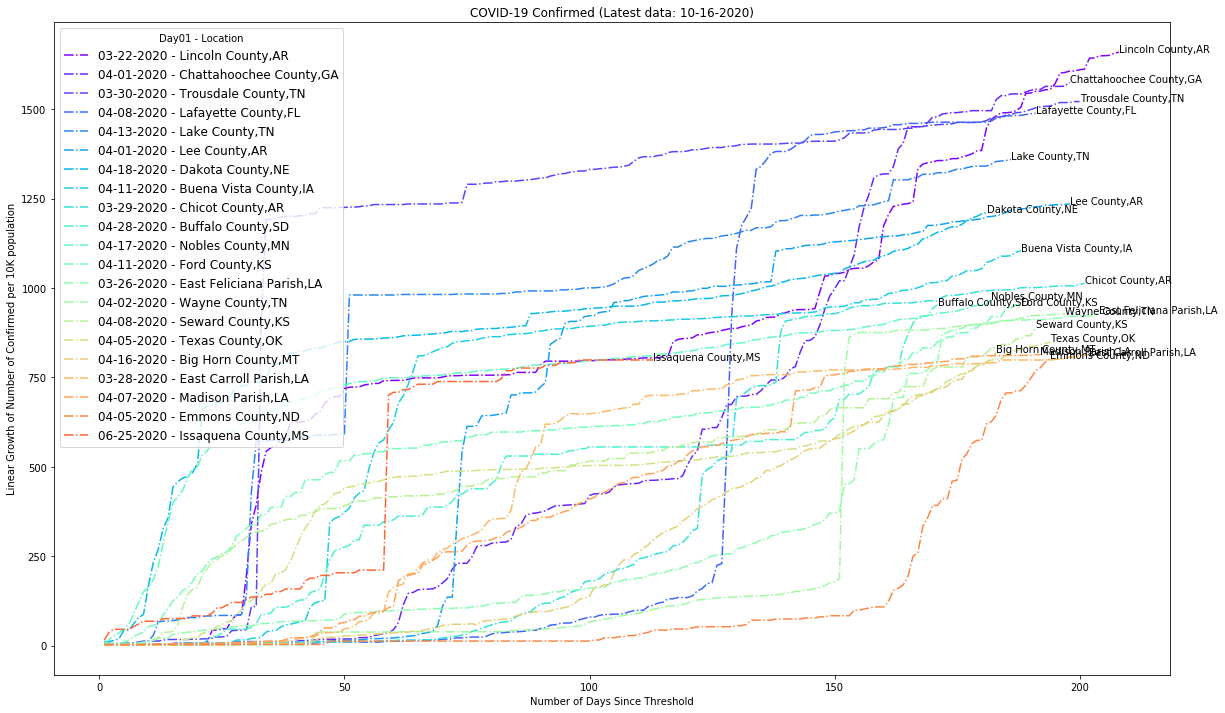

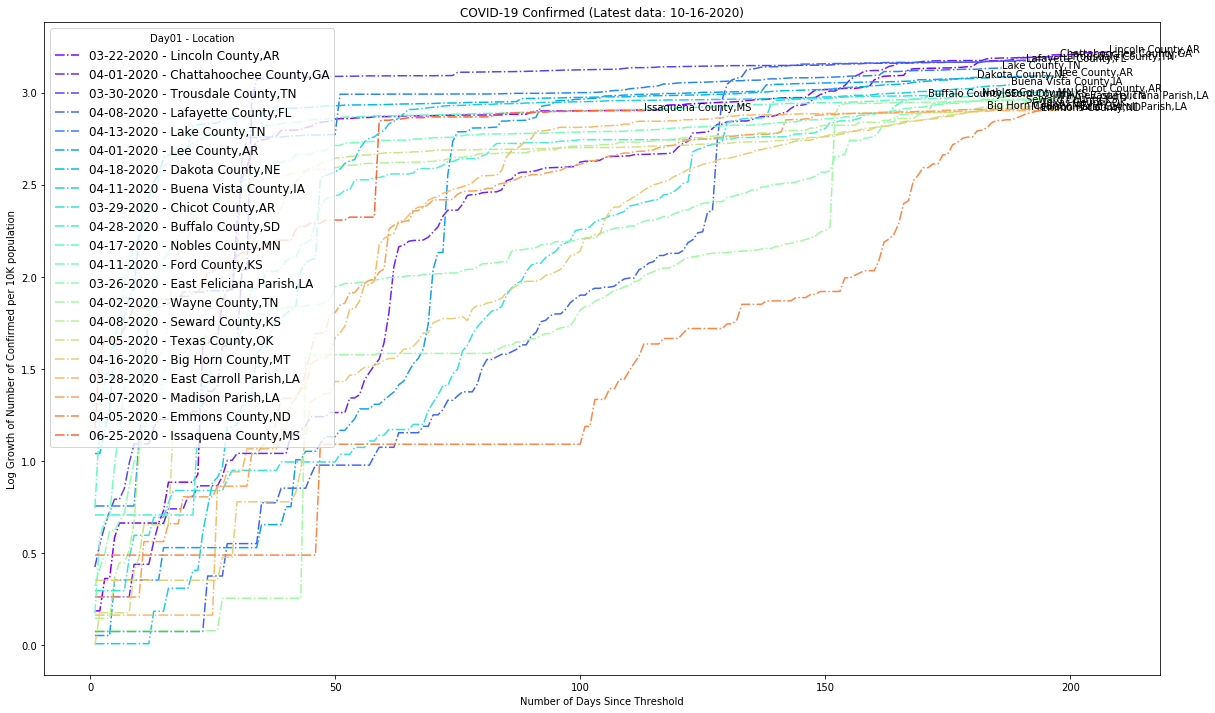

In [39]:
_plot_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')
_plot_log_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')

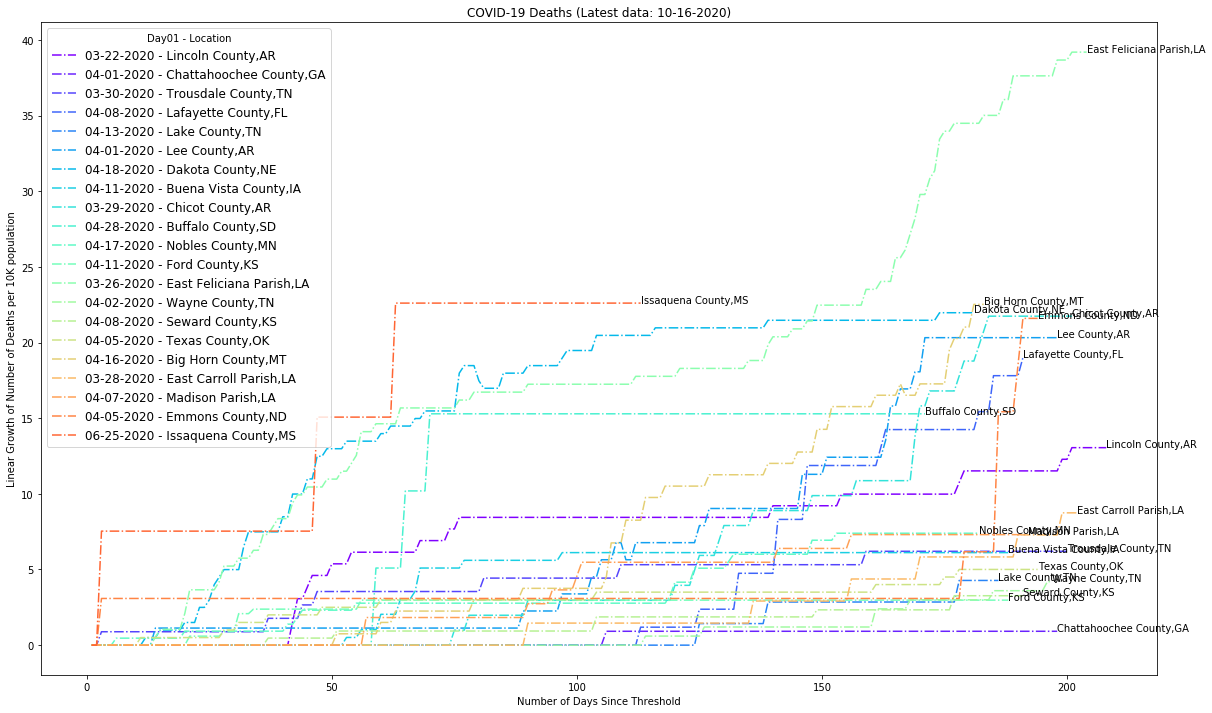

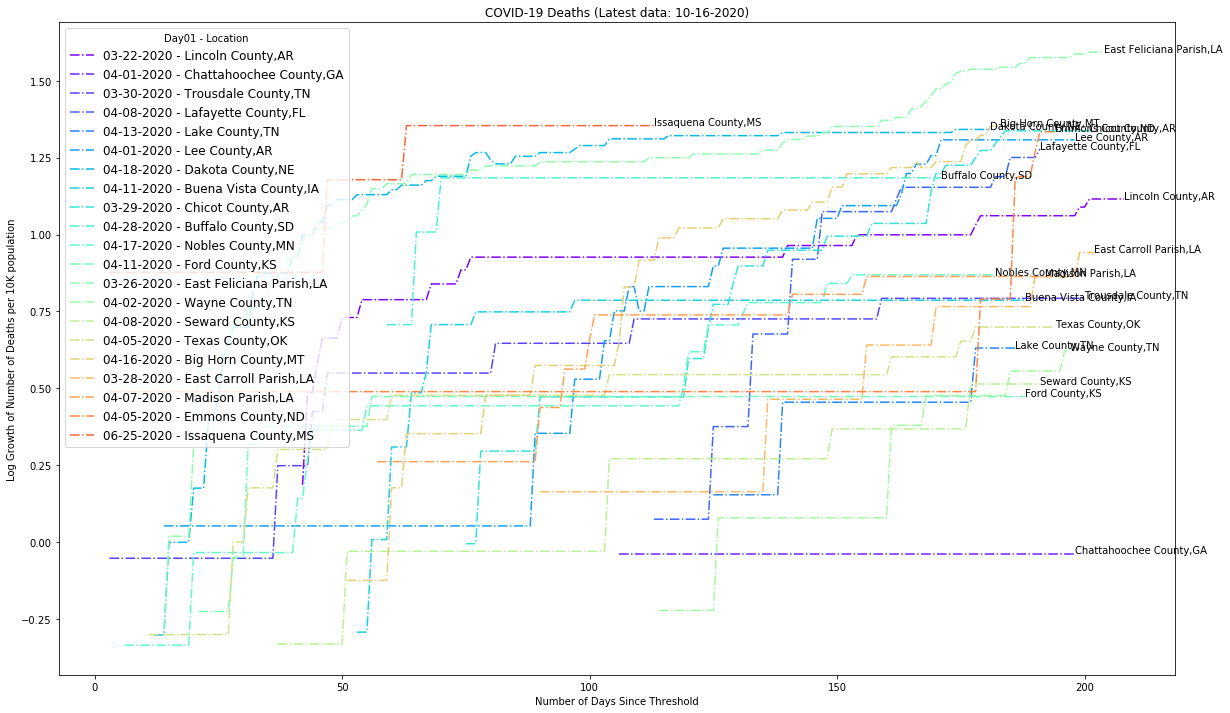

In [40]:
_plot_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')
_plot_log_trend(usaf_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')

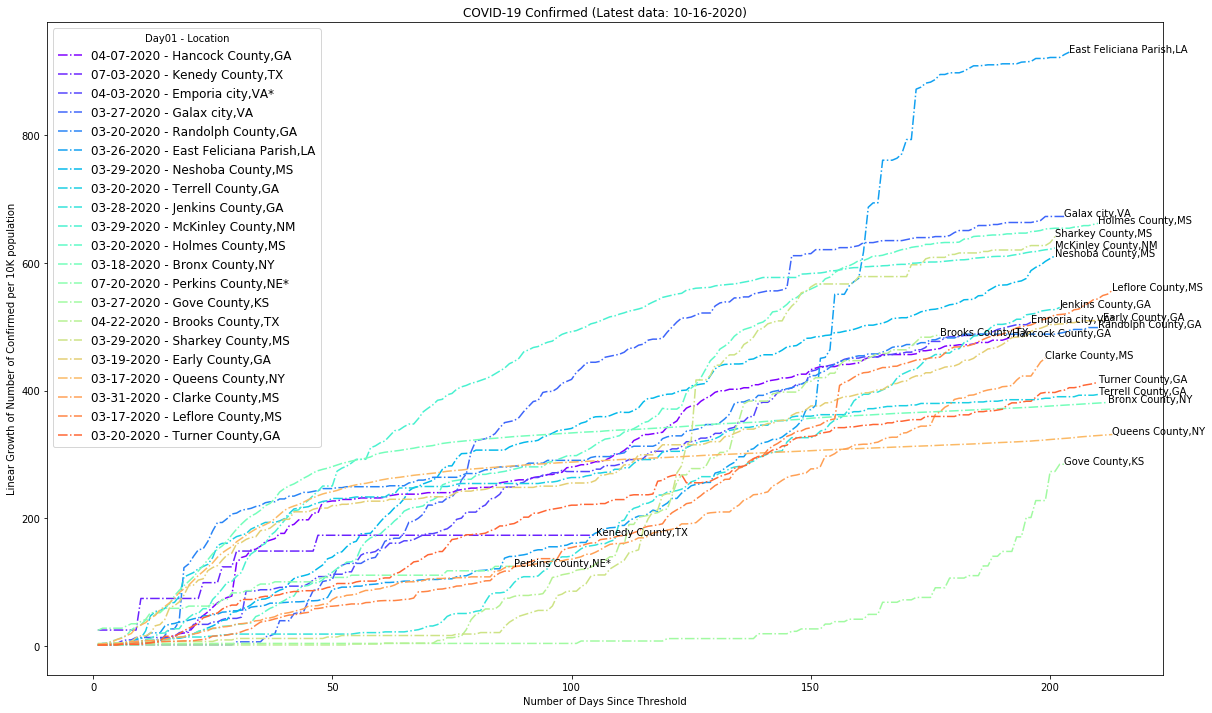

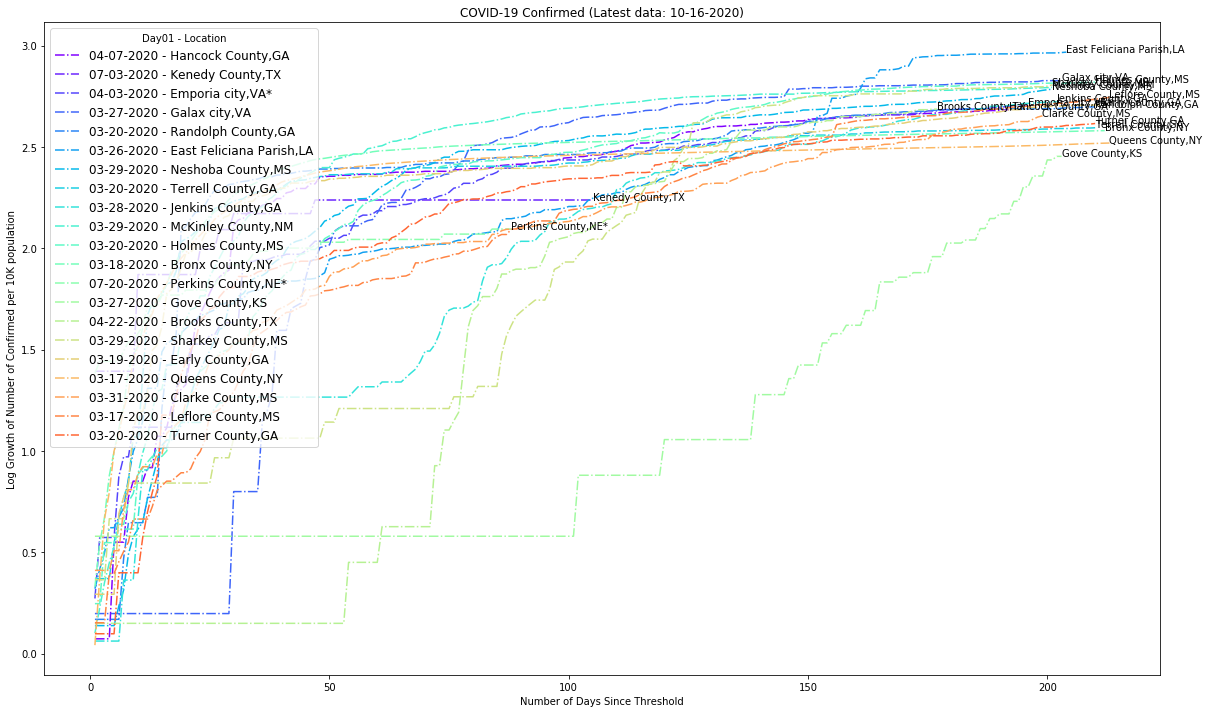

In [41]:
_plot_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Confirmed')
_plot_log_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Confirmed')

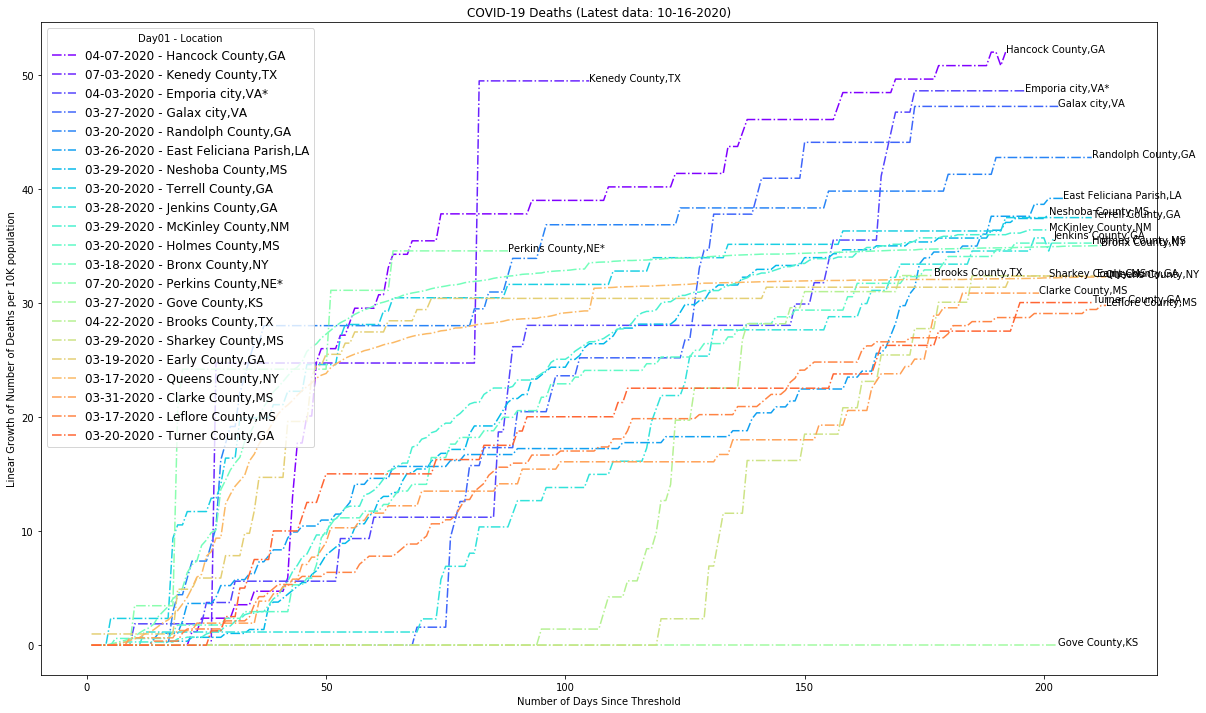

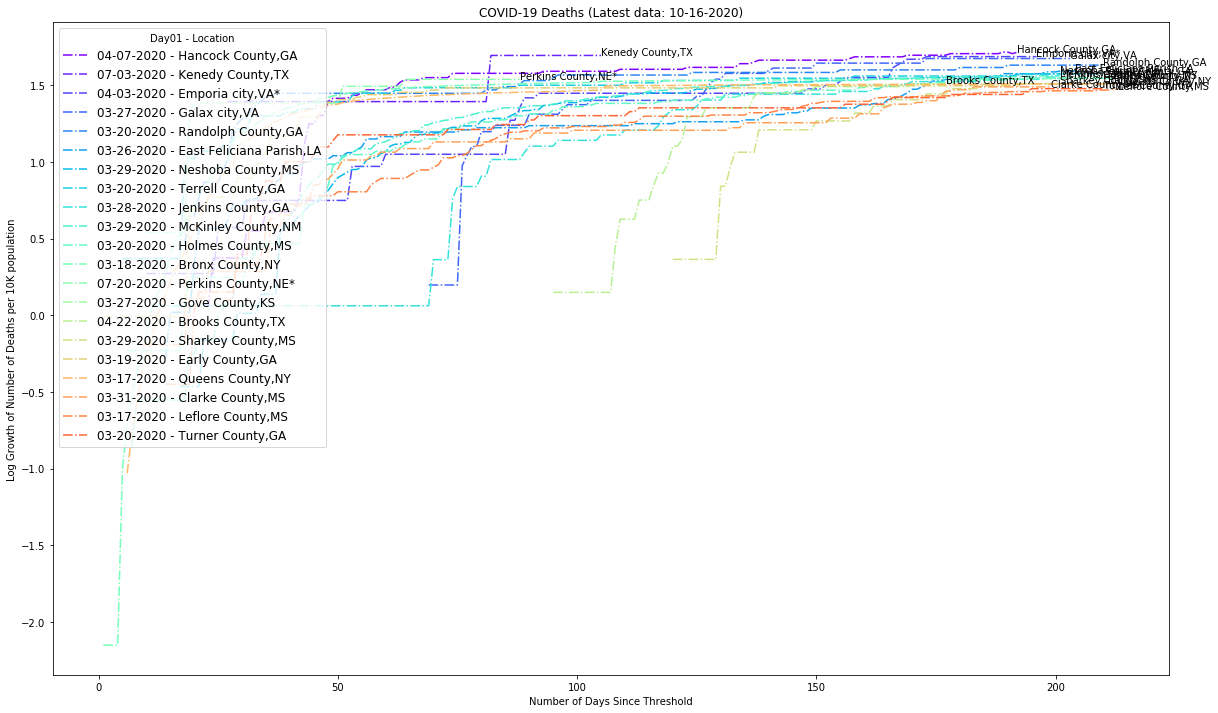

In [42]:
_plot_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Deaths')
_plot_log_trend(usaf_county_deaths_trend, us_top_deaths_locs, 'Deaths')

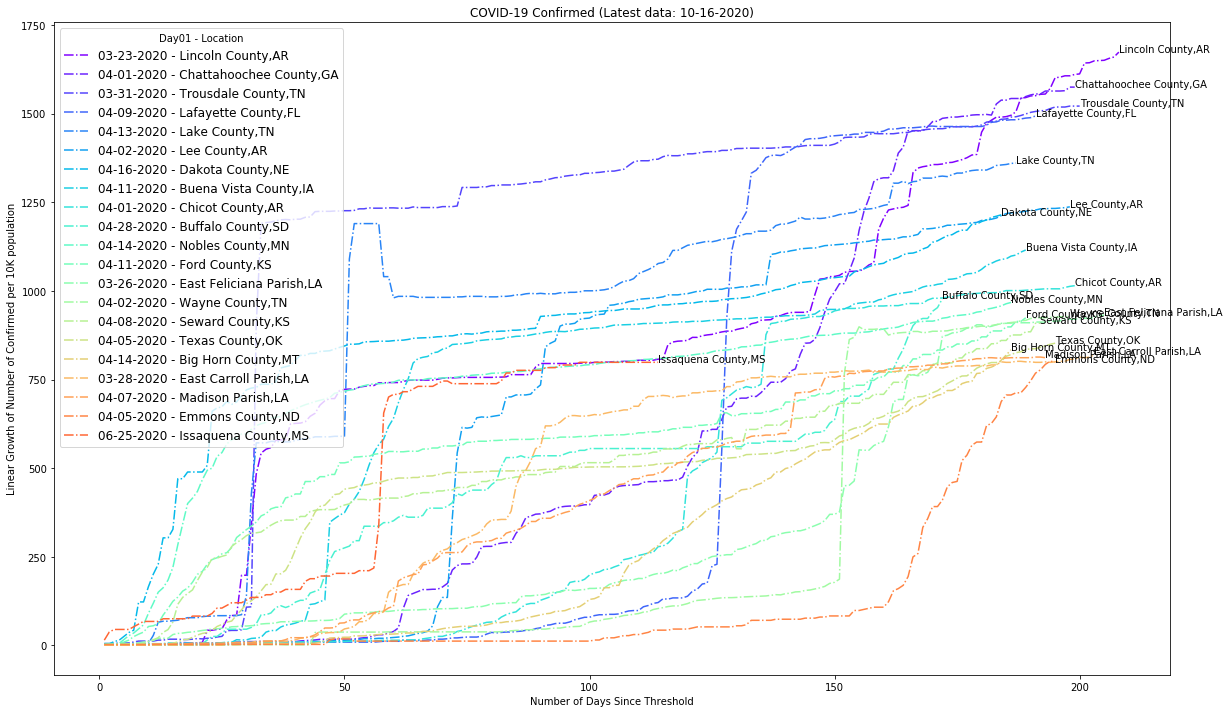

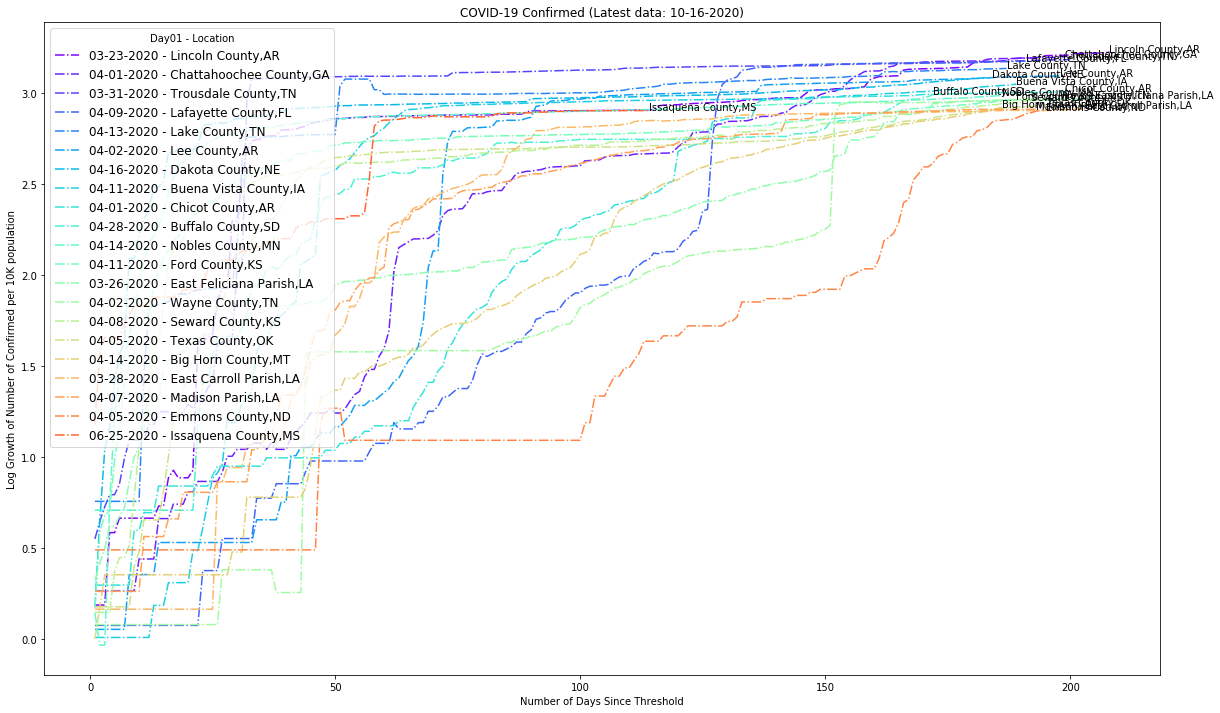

In [43]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Confirmed')

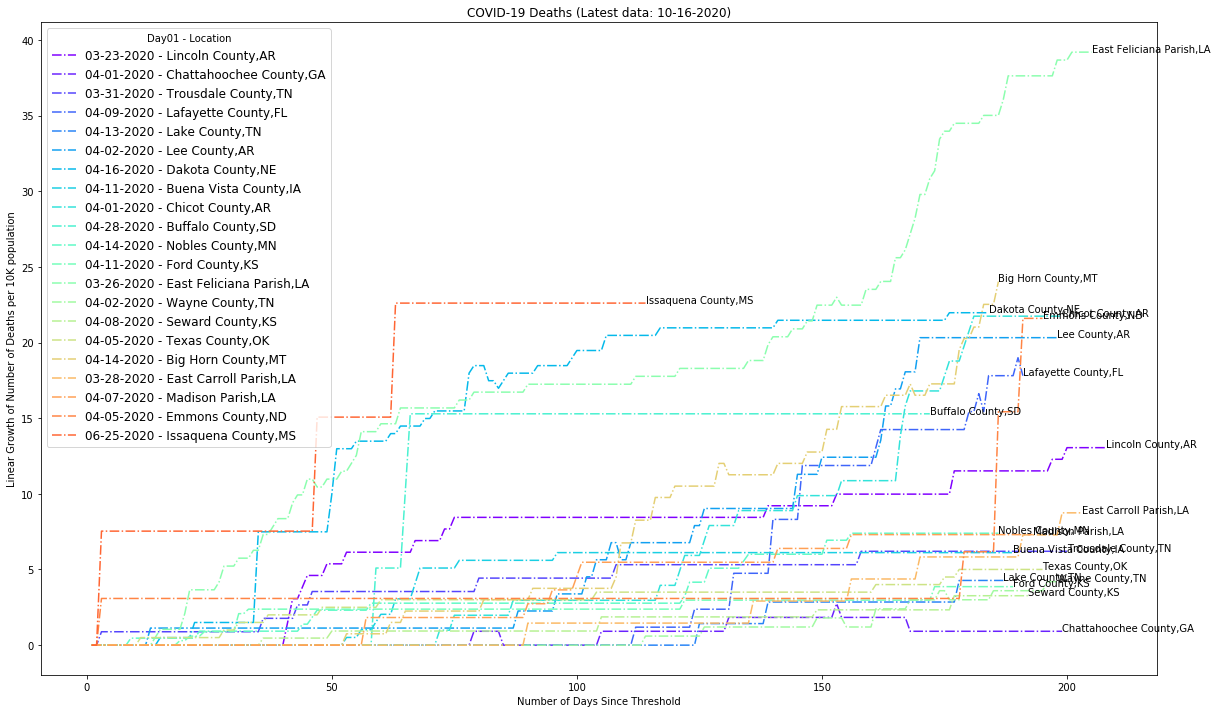

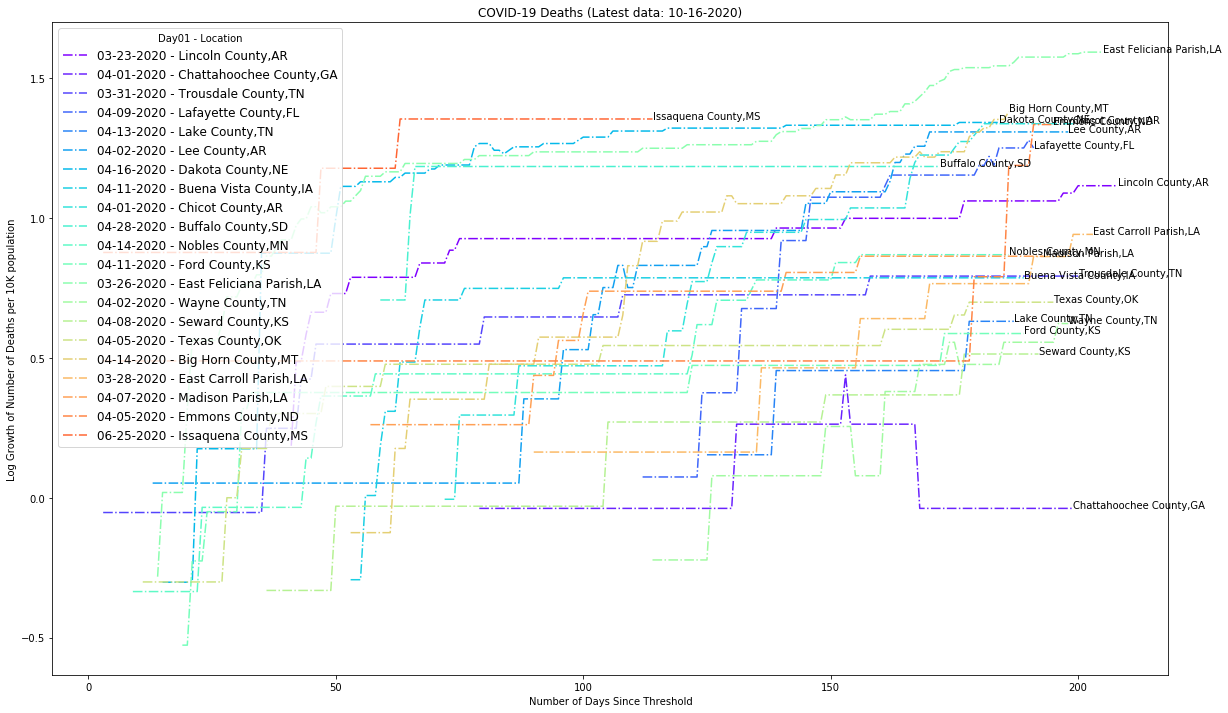

In [44]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Deaths')

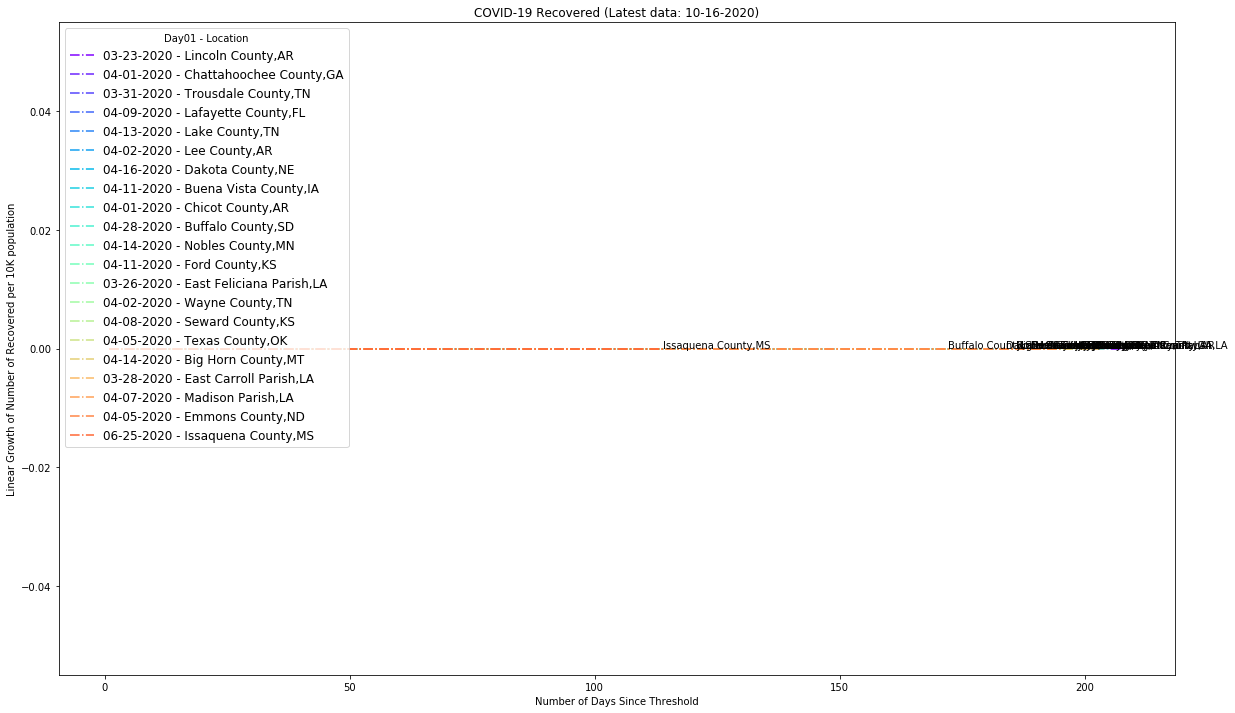

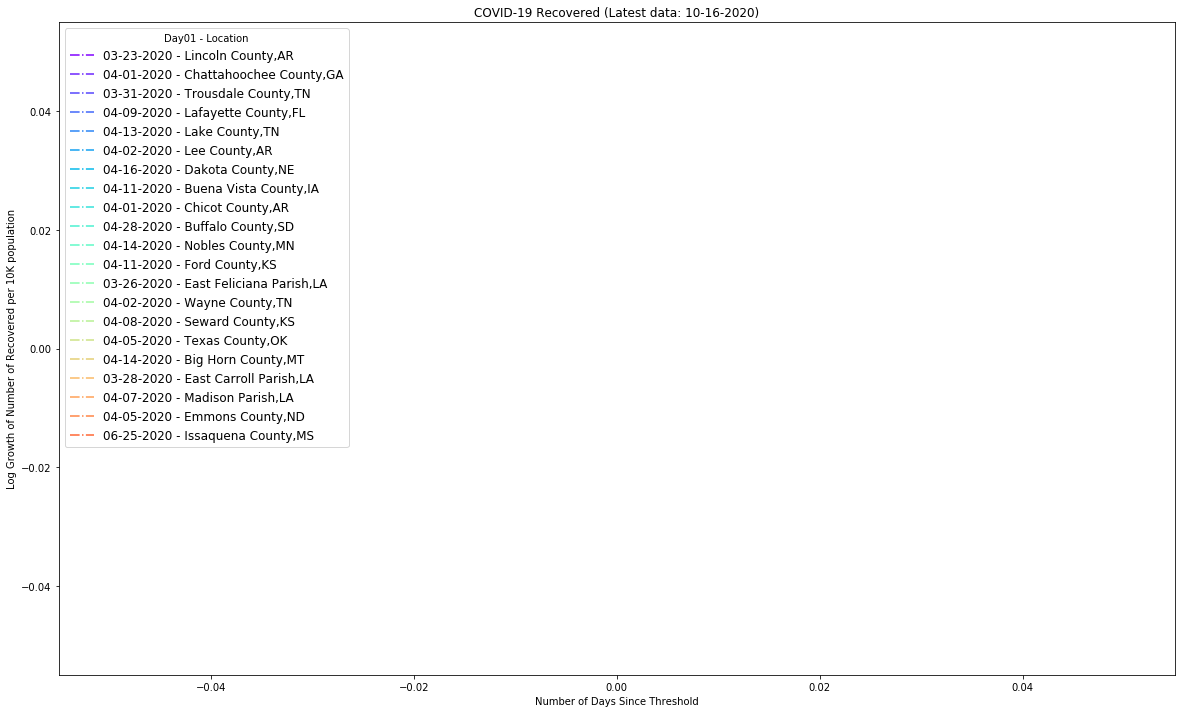

In [45]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Recovered')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Recovered')

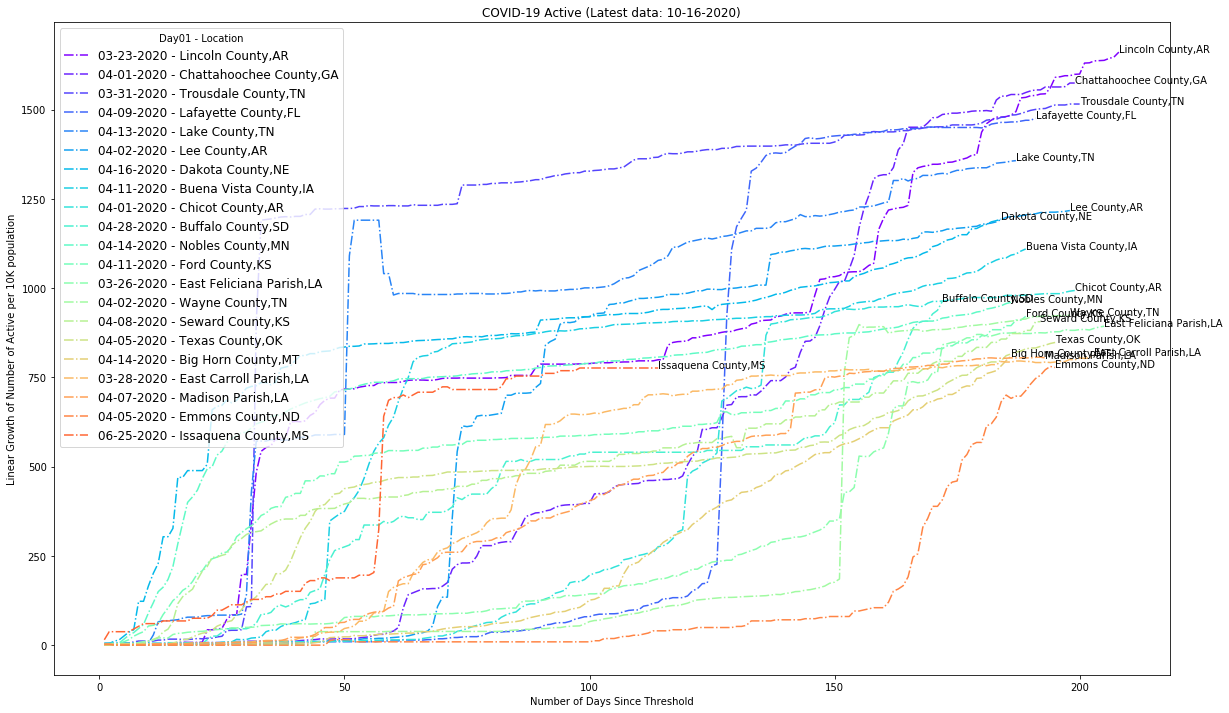

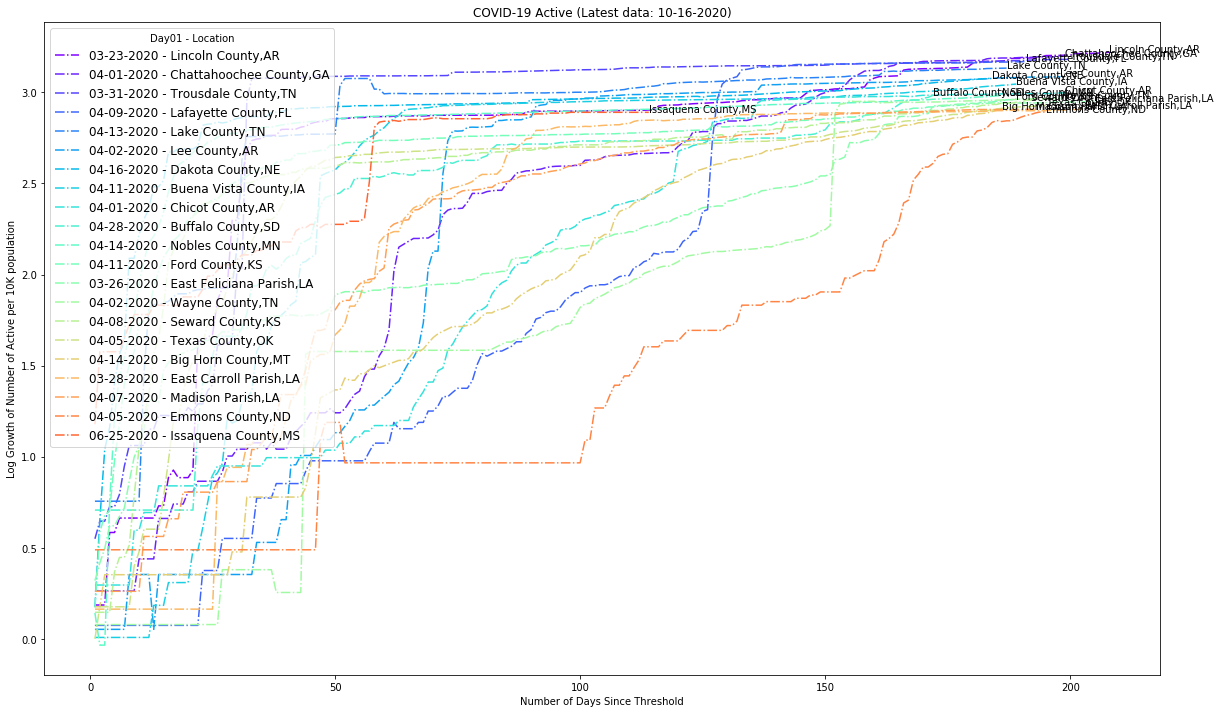

In [46]:
_plot_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Active')
_plot_log_trend(jh_county_confirmed_trend, us_top_confirmed_locs, 'Active')

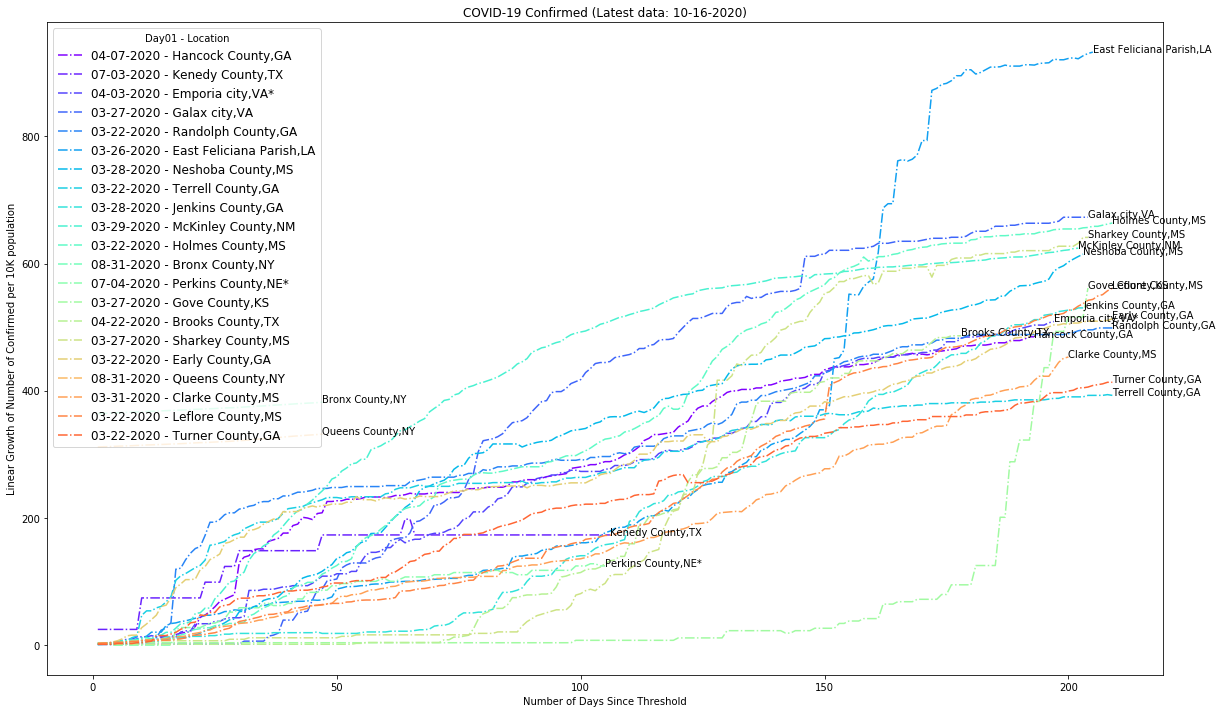

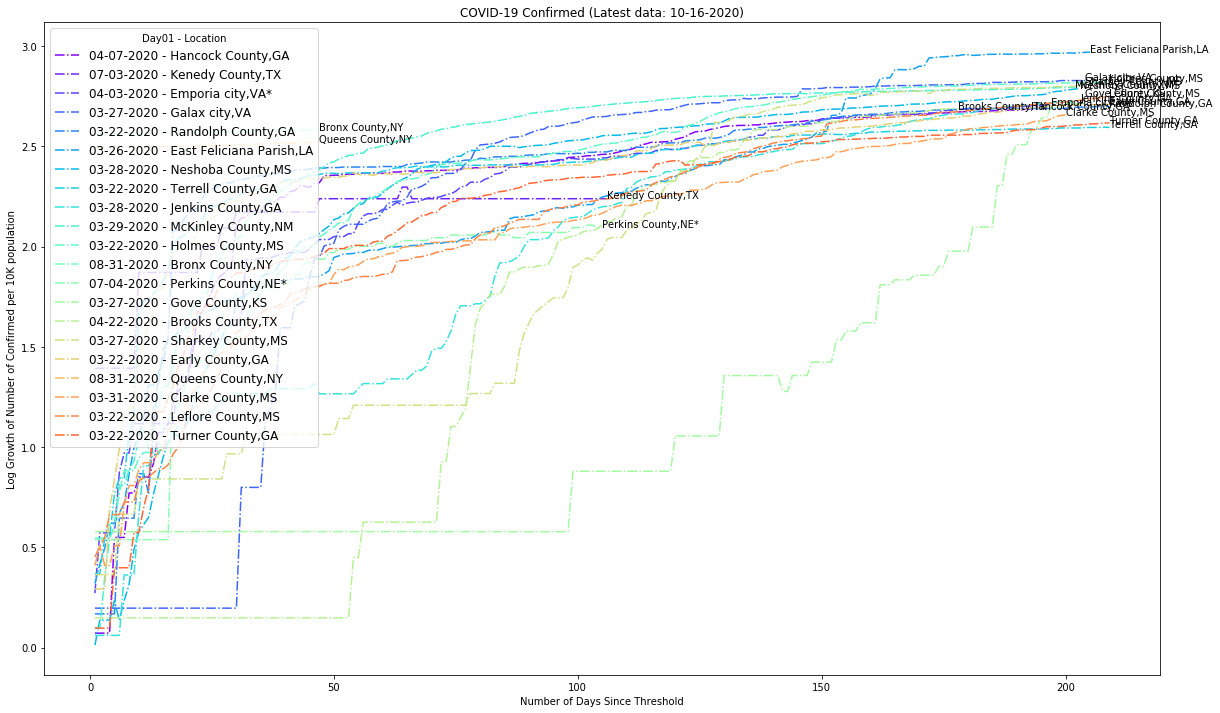

In [47]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Confirmed')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Confirmed')

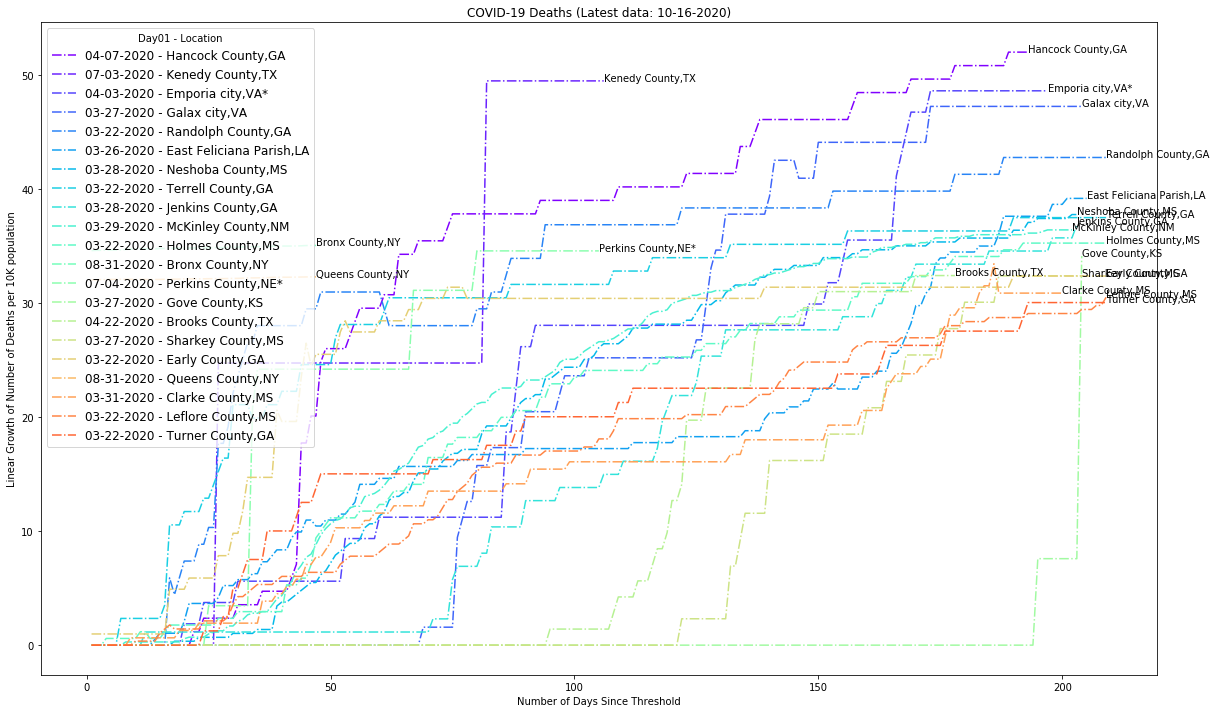

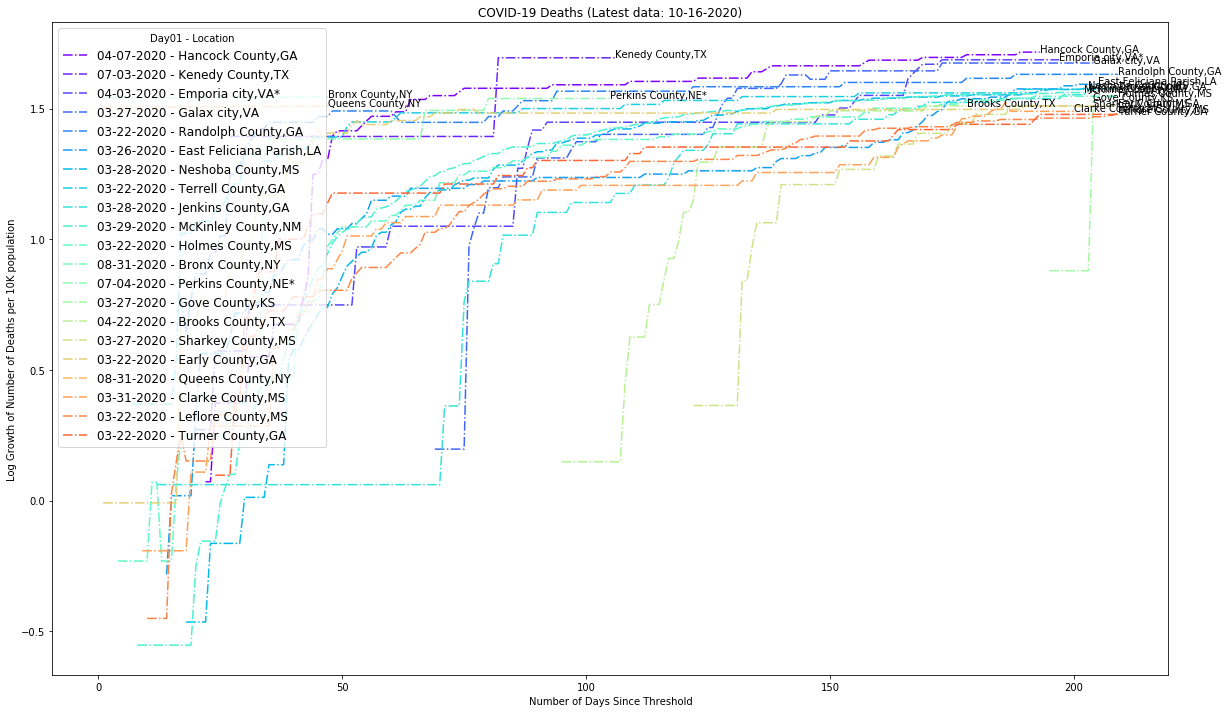

In [48]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Deaths')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Deaths')

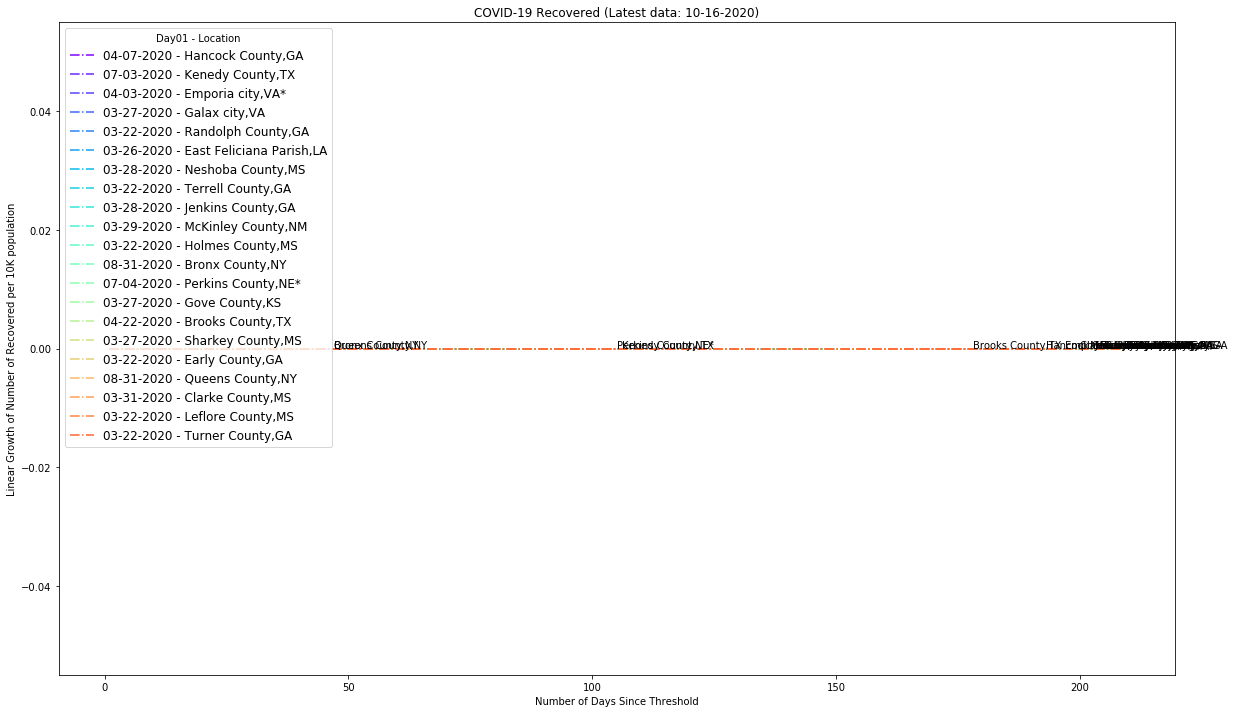

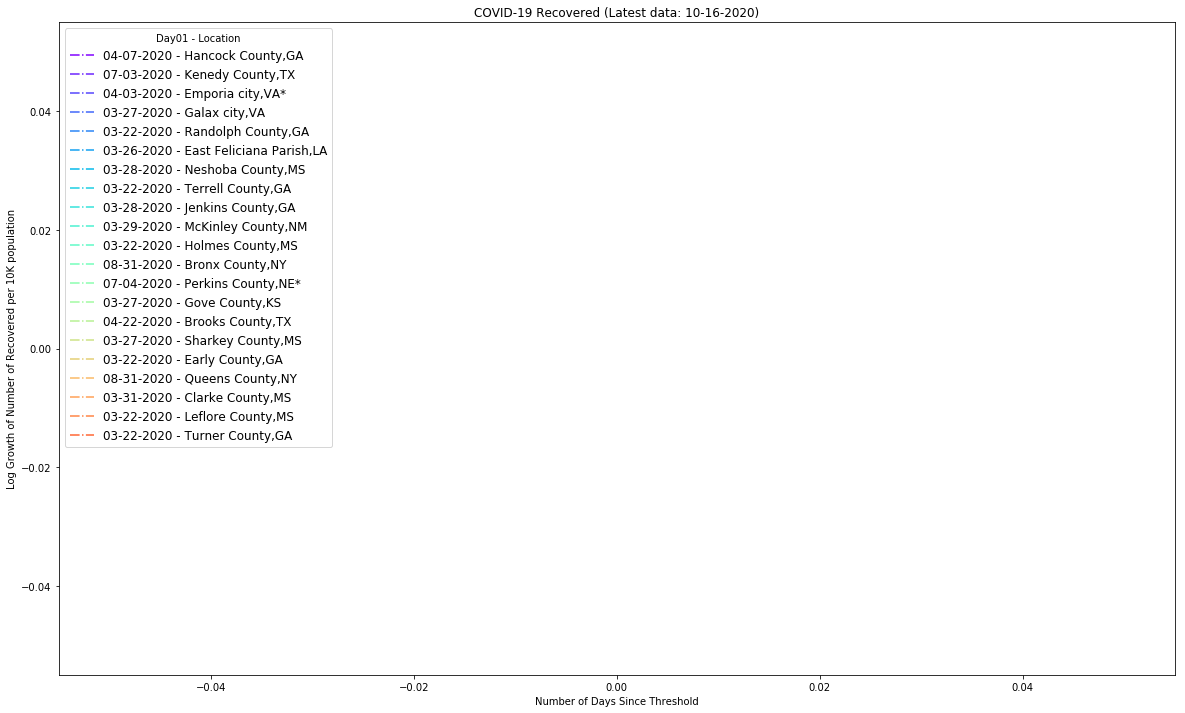

In [49]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Recovered')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Recovered')

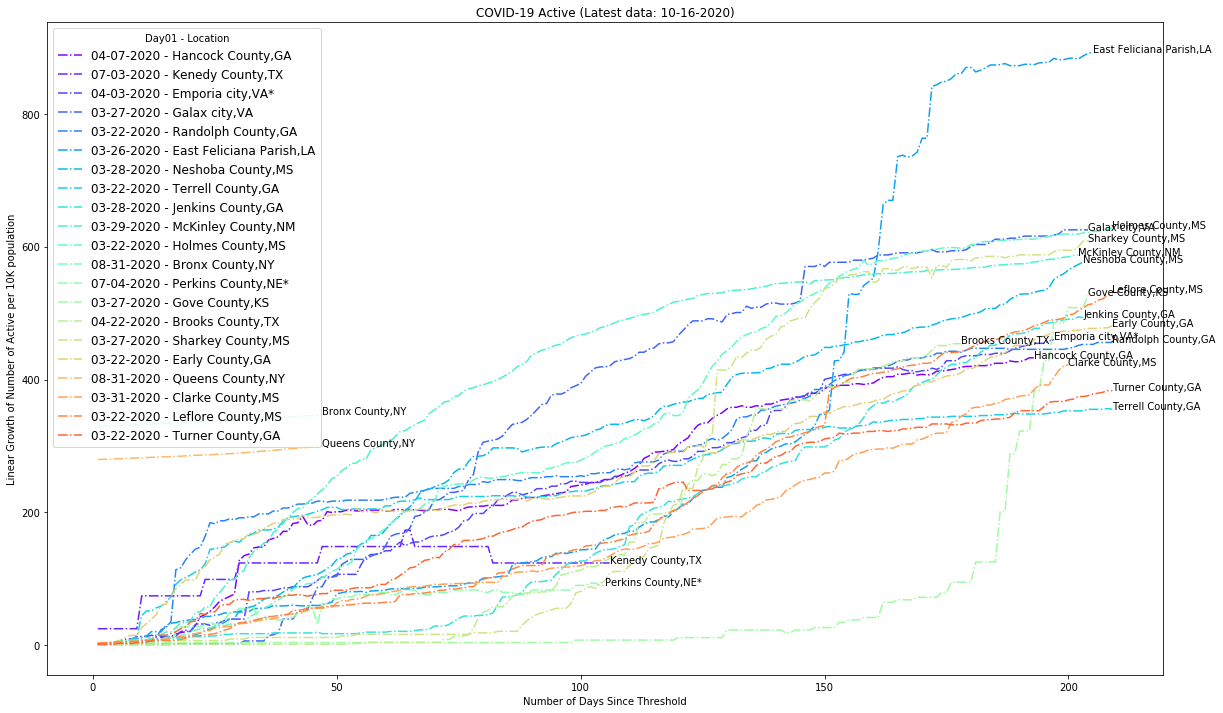

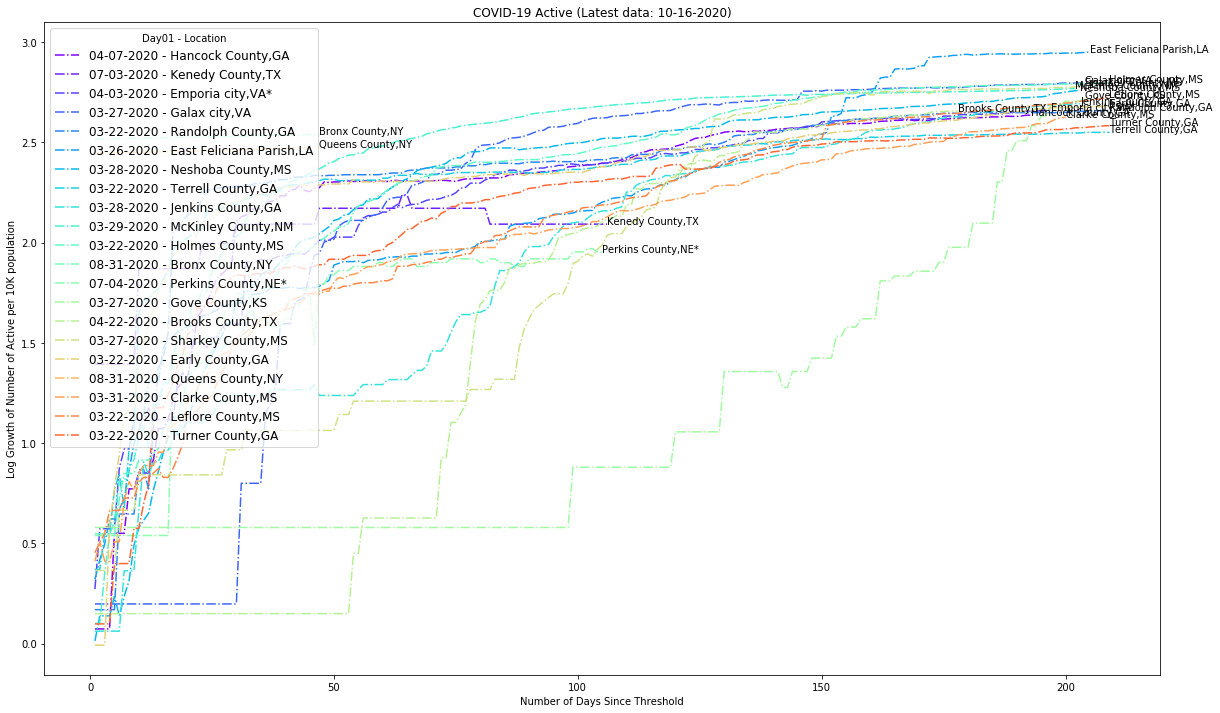

In [50]:
_plot_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Active')
_plot_log_trend(jh_county_deaths_trend, us_top_deaths_locs, 'Active')